In [1]:
!date

Fri Jul 30 11:17:23 PDT 2021


# All clusters DE

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [4]:
cluster_cmap = pd.read_csv('../../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='cluster_label',usecols=['cluster_label','cluster_color'])
cluster_cmap = cluster_cmap.drop_duplicates()
cluster_cmap = cluster_cmap.cluster_color.apply(lambda x: mcolors.to_rgb(x) )
cluster_cmap = cluster_cmap.to_dict()

In [5]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [6]:
import ast

In [7]:
gene = anndata.read_h5ad("../../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../../data/notebook/revision/isoform.h5ad")

In [8]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [9]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to genes with more than one isoform

In [10]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [11]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 181 ms, sys: 614 µs, total: 182 ms
Wall time: 180 ms


In [12]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [13]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 18175 × 12859
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'scaled'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 18175 × 68232
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length

In [14]:
isoform = isoform[isoform.obs.sort_values(["cluster_label", "cell_id"]).index]
gene = gene[gene.obs.sort_values(["cluster_label", "cell_id"]).index]

In [15]:
False in (gene.obs.cluster_label == isoform.obs.cluster_label)

False

In [16]:
isoform.obs

,cell_id,cluster_id,cluster_label,subclass_id,subclass_label,region_label,class_label,cluster_color,class_id,cell_counts,leiden,louvain
1239-1,SM-GE8ZJ_S122_E1-50,1,1_CR,3,CR,ORB,Glutamatergic,#00FF66,1,609860.12500,5,12
1242-1,SM-GE8ZJ_S125_E1-50,1,1_CR,3,CR,ORB,Glutamatergic,#00FF66,1,676942.06250,5,12
222-5,SM-GE677_S270_E1-50,2,2_Meis2,28,Meis2,AI,GABAergic,#C60C0F,0,346720.09375,31,25
1315-5,SM-GE67M_S288_E1-50,2,2_Meis2,28,Meis2,AI,GABAergic,#C60C0F,0,461417.25000,31,25
103-1,SM-GE67N_S183_E1-50,2,2_Meis2,28,Meis2,ORB,GABAergic,#C60C0F,0,570030.31250,31,25
...,...,...,...,...,...,...,...,...,...,...,...,...
967-3,SM-GE914_S008_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,305918.40625,26,21
989-3,SM-GE914_S196_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,450998.06250,26,21
1085-3,SM-GE915_S116_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,331371.40625,26,21
1424-3,SM-GE91G_S253_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,497750.71875,26,21


# determine the isoforms

In [17]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


# do for all clusters with a certain number of cells per cluster

In [18]:
subclasses = np.sort(isoform.obs.subclass_label.unique())

subclasses = np.setdiff1d(subclasses, ["L5 IT", "Low Quality"]) 

In [19]:
%%time
n_cells = 20

de_clusters = []
de_genes = []
de_isoforms = []
for cidx, c in enumerate(subclasses):
    print(f"{cidx+1} of {len(subclasses)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"subclass_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"subclass_label == '{c}'")].copy()
    
    big_enough_clusters = tmp_gene.obs["cluster_label"].value_counts()[tmp_gene.obs["cluster_label"].value_counts()>n_cells].index.values
    if len(big_enough_clusters) > 1:
        tmp_isoform = tmp_isoform[tmp_isoform.obs["cluster_label"].isin(big_enough_clusters)].copy()
        tmp_gene = tmp_gene[tmp_gene.obs["cluster_label"].isin(big_enough_clusters)].copy()
    #if tmp_isoform.shape[0] >= n_cells: # cluster must have at least 20 cells #this is checking subclasses, not clusters!
     #   if tmp_isoform.obs.cluster_label.nunique()>1:
            
            
        de_clusters.append(c)
        ####### Genes
        mat           = tmp_gene.layers["log1p"].todense()
        components    = tmp_gene.obs.cell_id.values
        features      = tmp_gene.var.gene_name.values
        assignments   = tmp_gene.obs.cluster_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in cluster
        corr_method   = "bonferroni"

        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

        s = stat

        markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

        # convert the 0 pvalues to the smallest possible float
        markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
        markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
        de_genes.append(markers_gene)



        ######### Isoforms
        mat           = tmp_isoform.layers["log1p"].todense()
        components    = tmp_isoform.obs.cell_id.values
        features      = tmp_isoform.var.transcript_name.values
        assignments   = tmp_isoform.obs.cluster_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in cluster
        corr_method   = "bonferroni"


        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

        s = stat

        markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)
        markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
        de_isoforms.append(markers_isoform)

1 of 39: Astro
2 of 39: CA1-ProS


30-Jul-21 11:18:15 - 1 of 14 assignments: 329_CA1-ProS
30-Jul-21 11:18:15 - 2 of 14 assignments: 330_CA1-ProS
30-Jul-21 11:18:16 - 3 of 14 assignments: 333_CA1-ProS
30-Jul-21 11:18:16 - 4 of 14 assignments: 336_CA1-ve
30-Jul-21 11:18:16 - 5 of 14 assignments: 337_CA1
30-Jul-21 11:18:16 - 6 of 14 assignments: 338_CA1
30-Jul-21 11:18:16 - 7 of 14 assignments: 339_CA1
30-Jul-21 11:18:16 - 8 of 14 assignments: 340_CA1
30-Jul-21 11:18:16 - 9 of 14 assignments: 341_CA1
30-Jul-21 11:18:17 - 10 of 14 assignments: 342_CA1
30-Jul-21 11:18:17 - 11 of 14 assignments: 344_CA1
30-Jul-21 11:18:17 - 12 of 14 assignments: 346_CA1-do
30-Jul-21 11:18:17 - 13 of 14 assignments: 347_CA1-do
30-Jul-21 11:18:17 - 14 of 14 assignments: 348_CA1-do
30-Jul-21 11:18:19 - 1 of 14 assignments: 329_CA1-ProS
30-Jul-21 11:18:20 - 2 of 14 assignments: 330_CA1-ProS
30-Jul-21 11:18:20 - 3 of 14 assignments: 333_CA1-ProS
30-Jul-21 11:18:21 - 4 of 14 assignments: 336_CA1-ve
30-Jul-21 11:18:21 - 5 of 14 assignments: 337_CA1


3 of 39: CA3


30-Jul-21 11:18:28 - 1 of 6 assignments: 352_CA3-ve
30-Jul-21 11:18:28 - 2 of 6 assignments: 354_CA3-ve
30-Jul-21 11:18:28 - 3 of 6 assignments: 355_CA3-ve
30-Jul-21 11:18:28 - 4 of 6 assignments: 356_CA3-do
30-Jul-21 11:18:28 - 5 of 6 assignments: 357_CA3-do
30-Jul-21 11:18:28 - 6 of 6 assignments: 358_CA3-do
30-Jul-21 11:18:29 - 1 of 6 assignments: 352_CA3-ve
30-Jul-21 11:18:29 - 2 of 6 assignments: 354_CA3-ve
30-Jul-21 11:18:29 - 3 of 6 assignments: 355_CA3-ve
30-Jul-21 11:18:29 - 4 of 6 assignments: 356_CA3-do
30-Jul-21 11:18:29 - 5 of 6 assignments: 357_CA3-do
30-Jul-21 11:18:29 - 6 of 6 assignments: 358_CA3-do


4 of 39: CR
5 of 39: CT SUB


30-Jul-21 11:18:31 - 1 of 3 assignments: 294_CT SUB
30-Jul-21 11:18:31 - 2 of 3 assignments: 296_CT SUB
30-Jul-21 11:18:31 - 3 of 3 assignments: 297_CT SUB
30-Jul-21 11:18:31 - 1 of 3 assignments: 294_CT SUB
30-Jul-21 11:18:31 - 2 of 3 assignments: 296_CT SUB
30-Jul-21 11:18:31 - 3 of 3 assignments: 297_CT SUB


6 of 39: Car3


30-Jul-21 11:18:41 - 1 of 2 assignments: 237_Car3
30-Jul-21 11:18:41 - 2 of 2 assignments: 238_Car3
30-Jul-21 11:18:41 - 1 of 2 assignments: 237_Car3
30-Jul-21 11:18:43 - 2 of 2 assignments: 238_Car3


7 of 39: DG


30-Jul-21 11:19:21 - 1 of 3 assignments: 362_DG
30-Jul-21 11:19:21 - 2 of 3 assignments: 363_DG
30-Jul-21 11:19:21 - 3 of 3 assignments: 364_DG
30-Jul-21 11:19:22 - 1 of 3 assignments: 362_DG
30-Jul-21 11:19:23 - 2 of 3 assignments: 363_DG
30-Jul-21 11:19:23 - 3 of 3 assignments: 364_DG


8 of 39: IG-FC
9 of 39: L2  IT ENTl
10 of 39: L2 IT ENTm
11 of 39: L2/3 IT CTX


30-Jul-21 11:19:30 - 1 of 4 assignments: 164_L2/3 IT CTX
30-Jul-21 11:19:30 - 2 of 4 assignments: 165_L2/3 IT CTX
30-Jul-21 11:19:30 - 3 of 4 assignments: 167_L2/3 IT CTX
30-Jul-21 11:19:30 - 4 of 4 assignments: 168_L2/3 IT CTX
30-Jul-21 11:19:31 - 1 of 4 assignments: 164_L2/3 IT CTX
30-Jul-21 11:19:31 - 2 of 4 assignments: 165_L2/3 IT CTX
30-Jul-21 11:19:32 - 3 of 4 assignments: 167_L2/3 IT CTX
30-Jul-21 11:19:32 - 4 of 4 assignments: 168_L2/3 IT CTX


12 of 39: L2/3 IT ENTl


30-Jul-21 11:19:34 - 1 of 5 assignments: 153_L2/3 IT ENTl
30-Jul-21 11:19:34 - 2 of 5 assignments: 154_L2/3 IT ENTl
30-Jul-21 11:19:34 - 3 of 5 assignments: 156_L2/3 IT ENTl
30-Jul-21 11:19:34 - 4 of 5 assignments: 160_L2/3 IT ENTl
30-Jul-21 11:19:34 - 5 of 5 assignments: 161_L2/3 IT ENTl
30-Jul-21 11:19:35 - 1 of 5 assignments: 153_L2/3 IT ENTl
30-Jul-21 11:19:35 - 2 of 5 assignments: 154_L2/3 IT ENTl
30-Jul-21 11:19:35 - 3 of 5 assignments: 156_L2/3 IT ENTl
30-Jul-21 11:19:35 - 4 of 5 assignments: 160_L2/3 IT ENTl
30-Jul-21 11:19:35 - 5 of 5 assignments: 161_L2/3 IT ENTl


13 of 39: L2/3 IT PPP


30-Jul-21 11:19:37 - 1 of 2 assignments: 133_L2 IT RSPv-POST-PRE
30-Jul-21 11:19:37 - 2 of 2 assignments: 145_L2/3 IT PAR
30-Jul-21 11:19:37 - 1 of 2 assignments: 133_L2 IT RSPv-POST-PRE
30-Jul-21 11:19:37 - 2 of 2 assignments: 145_L2/3 IT PAR


14 of 39: L2/3 IT RHP
15 of 39: L3 IT ENT


30-Jul-21 11:19:40 - 1 of 6 assignments: 135_L3 IT ENTm
30-Jul-21 11:19:40 - 2 of 6 assignments: 136_L3 IT ENTm
30-Jul-21 11:19:40 - 3 of 6 assignments: 137_L3 IT ENTm
30-Jul-21 11:19:40 - 4 of 6 assignments: 138_L3 IT ENTm
30-Jul-21 11:19:40 - 5 of 6 assignments: 139_L3 IT ENTl
30-Jul-21 11:19:40 - 6 of 6 assignments: 140_L3 IT ENTl
30-Jul-21 11:19:41 - 1 of 6 assignments: 135_L3 IT ENTm
30-Jul-21 11:19:41 - 2 of 6 assignments: 136_L3 IT ENTm
30-Jul-21 11:19:42 - 3 of 6 assignments: 137_L3 IT ENTm
30-Jul-21 11:19:42 - 4 of 6 assignments: 138_L3 IT ENTm
30-Jul-21 11:19:42 - 5 of 6 assignments: 139_L3 IT ENTl
30-Jul-21 11:19:42 - 6 of 6 assignments: 140_L3 IT ENTl


16 of 39: L4 RSP-ACA
17 of 39: L4/5 IT CTX


30-Jul-21 11:19:46 - 1 of 10 assignments: 179_L4 IT CTX
30-Jul-21 11:19:46 - 2 of 10 assignments: 180_L4 IT CTX
30-Jul-21 11:19:46 - 3 of 10 assignments: 184_L4/5 IT CTX
30-Jul-21 11:19:47 - 4 of 10 assignments: 185_L4/5 IT CTX
30-Jul-21 11:19:47 - 5 of 10 assignments: 186_L4/5 IT CTX
30-Jul-21 11:19:47 - 6 of 10 assignments: 187_L4/5 IT CTX
30-Jul-21 11:19:47 - 7 of 10 assignments: 188_L4/5 IT CTX
30-Jul-21 11:19:47 - 8 of 10 assignments: 189_L4/5 IT CTX
30-Jul-21 11:19:47 - 9 of 10 assignments: 191_L4/5 IT CTX
30-Jul-21 11:19:47 - 10 of 10 assignments: 192_L4/5 IT CTX
30-Jul-21 11:19:49 - 1 of 10 assignments: 179_L4 IT CTX
30-Jul-21 11:19:49 - 2 of 10 assignments: 180_L4 IT CTX
30-Jul-21 11:19:49 - 3 of 10 assignments: 184_L4/5 IT CTX
30-Jul-21 11:19:49 - 4 of 10 assignments: 185_L4/5 IT CTX
30-Jul-21 11:19:49 - 5 of 10 assignments: 186_L4/5 IT CTX
30-Jul-21 11:19:50 - 6 of 10 assignments: 187_L4/5 IT CTX
30-Jul-21 11:19:50 - 7 of 10 assignments: 188_L4/5 IT CTX
30-Jul-21 11:19:50 - 

18 of 39: L5 IT CTX


30-Jul-21 11:19:52 - 1 of 4 assignments: 194_L5 IT RSP-ACA
30-Jul-21 11:19:52 - 2 of 4 assignments: 200_L5 IT CTX
30-Jul-21 11:19:52 - 3 of 4 assignments: 203_L5/6 IT CTX
30-Jul-21 11:19:52 - 4 of 4 assignments: 204_L5/6 IT CTX
30-Jul-21 11:19:53 - 1 of 4 assignments: 194_L5 IT RSP-ACA
30-Jul-21 11:19:53 - 2 of 4 assignments: 200_L5 IT CTX
30-Jul-21 11:19:53 - 3 of 4 assignments: 203_L5/6 IT CTX
30-Jul-21 11:19:53 - 4 of 4 assignments: 204_L5/6 IT CTX


19 of 39: L5 IT TPE-ENT


30-Jul-21 11:19:54 - 1 of 5 assignments: 210_L5/6 IT TPE-ENT
30-Jul-21 11:19:54 - 2 of 5 assignments: 212_L5/6 IT TPE-ENT
30-Jul-21 11:19:54 - 3 of 5 assignments: 213_L5/6 IT TPE-ENT
30-Jul-21 11:19:54 - 4 of 5 assignments: 214_L5/6 IT PFC
30-Jul-21 11:19:54 - 5 of 5 assignments: 216_L5/6 IT TPE-ENT
30-Jul-21 11:19:55 - 1 of 5 assignments: 210_L5/6 IT TPE-ENT
30-Jul-21 11:19:55 - 2 of 5 assignments: 212_L5/6 IT TPE-ENT
30-Jul-21 11:19:55 - 3 of 5 assignments: 213_L5/6 IT TPE-ENT
30-Jul-21 11:19:55 - 4 of 5 assignments: 214_L5/6 IT PFC
30-Jul-21 11:19:55 - 5 of 5 assignments: 216_L5/6 IT TPE-ENT


20 of 39: L5 NP CTX


30-Jul-21 11:19:57 - 1 of 3 assignments: 265_L5/6 NP CTX
30-Jul-21 11:19:57 - 2 of 3 assignments: 266_L5/6 NP CTX
30-Jul-21 11:19:57 - 3 of 3 assignments: 267_L5/6 NP CTX
30-Jul-21 11:19:57 - 1 of 3 assignments: 265_L5/6 NP CTX
30-Jul-21 11:19:57 - 2 of 3 assignments: 266_L5/6 NP CTX
30-Jul-21 11:19:57 - 3 of 3 assignments: 267_L5/6 NP CTX


21 of 39: L5 PPP
22 of 39: L5 PT CTX


30-Jul-21 11:19:58 - 1 of 3 assignments: 253_L5 PT CTX
30-Jul-21 11:19:58 - 2 of 3 assignments: 255_L5 PT CTX
30-Jul-21 11:19:58 - 3 of 3 assignments: 260_L5 PT CTX
30-Jul-21 11:19:58 - 1 of 3 assignments: 253_L5 PT CTX
30-Jul-21 11:19:58 - 2 of 3 assignments: 255_L5 PT CTX
30-Jul-21 11:19:58 - 3 of 3 assignments: 260_L5 PT CTX


23 of 39: L6 CT CTX


30-Jul-21 11:20:02 - 1 of 8 assignments: 279_L6 CT CTX
30-Jul-21 11:20:02 - 2 of 8 assignments: 282_L6 CT CTX
30-Jul-21 11:20:02 - 3 of 8 assignments: 283_L6 CT CTX
30-Jul-21 11:20:02 - 4 of 8 assignments: 285_L6 CT CTX
30-Jul-21 11:20:02 - 5 of 8 assignments: 288_L6 CT CTX
30-Jul-21 11:20:02 - 6 of 8 assignments: 289_L6 CT CTX
30-Jul-21 11:20:02 - 7 of 8 assignments: 290_L6 CT CTX
30-Jul-21 11:20:02 - 8 of 8 assignments: 293_L6 CT CTX
30-Jul-21 11:20:03 - 1 of 8 assignments: 279_L6 CT CTX
30-Jul-21 11:20:03 - 2 of 8 assignments: 282_L6 CT CTX
30-Jul-21 11:20:03 - 3 of 8 assignments: 283_L6 CT CTX
30-Jul-21 11:20:04 - 4 of 8 assignments: 285_L6 CT CTX
30-Jul-21 11:20:04 - 5 of 8 assignments: 288_L6 CT CTX
30-Jul-21 11:20:04 - 6 of 8 assignments: 289_L6 CT CTX
30-Jul-21 11:20:04 - 7 of 8 assignments: 290_L6 CT CTX
30-Jul-21 11:20:04 - 8 of 8 assignments: 293_L6 CT CTX


24 of 39: L6 IT CTX


30-Jul-21 11:20:07 - 1 of 8 assignments: 219_L6 IT CTX
30-Jul-21 11:20:07 - 2 of 8 assignments: 221_L6 IT CTX
30-Jul-21 11:20:07 - 3 of 8 assignments: 222_L6 IT CTX
30-Jul-21 11:20:07 - 4 of 8 assignments: 224_L6 IT CTX
30-Jul-21 11:20:07 - 5 of 8 assignments: 225_L6 IT CTX
30-Jul-21 11:20:07 - 6 of 8 assignments: 226_L6 IT CTX
30-Jul-21 11:20:07 - 7 of 8 assignments: 227_L6 IT CTX
30-Jul-21 11:20:07 - 8 of 8 assignments: 228_L6 IT CTX
30-Jul-21 11:20:09 - 1 of 8 assignments: 219_L6 IT CTX
30-Jul-21 11:20:09 - 2 of 8 assignments: 221_L6 IT CTX
30-Jul-21 11:20:09 - 3 of 8 assignments: 222_L6 IT CTX
30-Jul-21 11:20:09 - 4 of 8 assignments: 224_L6 IT CTX
30-Jul-21 11:20:09 - 5 of 8 assignments: 225_L6 IT CTX
30-Jul-21 11:20:09 - 6 of 8 assignments: 226_L6 IT CTX
30-Jul-21 11:20:09 - 7 of 8 assignments: 227_L6 IT CTX
30-Jul-21 11:20:09 - 8 of 8 assignments: 228_L6 IT CTX


25 of 39: L6 IT ENTl
26 of 39: L6b CTX


30-Jul-21 11:20:11 - 1 of 3 assignments: 303_L6b CTX
30-Jul-21 11:20:11 - 2 of 3 assignments: 304_L6b CTX
30-Jul-21 11:20:11 - 3 of 3 assignments: 310_L6b RHP
30-Jul-21 11:20:11 - 1 of 3 assignments: 303_L6b CTX
30-Jul-21 11:20:11 - 2 of 3 assignments: 304_L6b CTX
30-Jul-21 11:20:11 - 3 of 3 assignments: 310_L6b RHP


27 of 39: L6b/CT ENT


30-Jul-21 11:20:14 - 1 of 4 assignments: 298_L6 CT ENT
30-Jul-21 11:20:14 - 2 of 4 assignments: 299_L6 CT ENT
30-Jul-21 11:20:14 - 3 of 4 assignments: 300_L6b ENT
30-Jul-21 11:20:14 - 4 of 4 assignments: 302_L6b ENT
30-Jul-21 11:20:15 - 1 of 4 assignments: 298_L6 CT ENT
30-Jul-21 11:20:15 - 2 of 4 assignments: 299_L6 CT ENT
30-Jul-21 11:20:15 - 3 of 4 assignments: 300_L6b ENT
30-Jul-21 11:20:16 - 4 of 4 assignments: 302_L6b ENT


28 of 39: Lamp5


30-Jul-21 11:20:22 - 1 of 12 assignments: 10_Lamp5
30-Jul-21 11:20:22 - 2 of 12 assignments: 11_Lamp5
30-Jul-21 11:20:23 - 3 of 12 assignments: 12_Lamp5
30-Jul-21 11:20:23 - 4 of 12 assignments: 14_Lamp5
30-Jul-21 11:20:23 - 5 of 12 assignments: 16_Lamp5
30-Jul-21 11:20:23 - 6 of 12 assignments: 17_Lamp5
30-Jul-21 11:20:23 - 7 of 12 assignments: 19_Pax6
30-Jul-21 11:20:23 - 8 of 12 assignments: 5_Lamp5 Lhx6
30-Jul-21 11:20:23 - 9 of 12 assignments: 6_Lamp5 Lhx6
30-Jul-21 11:20:23 - 10 of 12 assignments: 7_Lamp5 Lhx6
30-Jul-21 11:20:23 - 11 of 12 assignments: 8_Lamp5 Lhx6
30-Jul-21 11:20:23 - 12 of 12 assignments: 9_Lamp5 Lhx6
30-Jul-21 11:20:25 - 1 of 12 assignments: 10_Lamp5
30-Jul-21 11:20:25 - 2 of 12 assignments: 11_Lamp5
30-Jul-21 11:20:26 - 3 of 12 assignments: 12_Lamp5
30-Jul-21 11:20:26 - 4 of 12 assignments: 14_Lamp5
30-Jul-21 11:20:26 - 5 of 12 assignments: 16_Lamp5
30-Jul-21 11:20:27 - 6 of 12 assignments: 17_Lamp5
30-Jul-21 11:20:27 - 7 of 12 assignments: 19_Pax6
30-Jul-21 

29 of 39: Meis2
30 of 39: Micro-PVM
31 of 39: NP PPP
32 of 39: NP SUB


30-Jul-21 11:20:31 - 1 of 4 assignments: 271_NP SUB
30-Jul-21 11:20:31 - 2 of 4 assignments: 272_NP SUB
30-Jul-21 11:20:31 - 3 of 4 assignments: 273_NP SUB
30-Jul-21 11:20:31 - 4 of 4 assignments: 274_NP SUB
30-Jul-21 11:20:32 - 1 of 4 assignments: 271_NP SUB
30-Jul-21 11:20:32 - 2 of 4 assignments: 272_NP SUB
30-Jul-21 11:20:32 - 3 of 4 assignments: 273_NP SUB
30-Jul-21 11:20:32 - 4 of 4 assignments: 274_NP SUB


33 of 39: Oligo
34 of 39: Pvalb


30-Jul-21 11:20:34 - 1 of 10 assignments: 109_Pvalb
30-Jul-21 11:20:35 - 2 of 10 assignments: 111_Pvalb
30-Jul-21 11:20:35 - 3 of 10 assignments: 112_Pvalb
30-Jul-21 11:20:35 - 4 of 10 assignments: 114_Pvalb
30-Jul-21 11:20:35 - 5 of 10 assignments: 116_Pvalb
30-Jul-21 11:20:35 - 6 of 10 assignments: 118_Pvalb
30-Jul-21 11:20:35 - 7 of 10 assignments: 119_Pvalb
30-Jul-21 11:20:35 - 8 of 10 assignments: 121_Pvalb
30-Jul-21 11:20:35 - 9 of 10 assignments: 122_Pvalb Vipr2
30-Jul-21 11:20:35 - 10 of 10 assignments: 123_Pvalb Vipr2
30-Jul-21 11:20:36 - 1 of 10 assignments: 109_Pvalb
30-Jul-21 11:20:36 - 2 of 10 assignments: 111_Pvalb
30-Jul-21 11:20:36 - 3 of 10 assignments: 112_Pvalb
30-Jul-21 11:20:37 - 4 of 10 assignments: 114_Pvalb
30-Jul-21 11:20:37 - 5 of 10 assignments: 116_Pvalb
30-Jul-21 11:20:37 - 6 of 10 assignments: 118_Pvalb
30-Jul-21 11:20:37 - 7 of 10 assignments: 119_Pvalb
30-Jul-21 11:20:37 - 8 of 10 assignments: 121_Pvalb
30-Jul-21 11:20:37 - 9 of 10 assignments: 122_Pvalb

35 of 39: SUB-ProS


30-Jul-21 11:20:41 - 1 of 6 assignments: 318_SUB
30-Jul-21 11:20:41 - 2 of 6 assignments: 319_SUB
30-Jul-21 11:20:41 - 3 of 6 assignments: 320_SUB
30-Jul-21 11:20:41 - 4 of 6 assignments: 321_SUB
30-Jul-21 11:20:41 - 5 of 6 assignments: 323_ProS
30-Jul-21 11:20:41 - 6 of 6 assignments: 324_ProS
30-Jul-21 11:20:42 - 1 of 6 assignments: 318_SUB
30-Jul-21 11:20:42 - 2 of 6 assignments: 319_SUB
30-Jul-21 11:20:42 - 3 of 6 assignments: 320_SUB
30-Jul-21 11:20:42 - 4 of 6 assignments: 321_SUB
30-Jul-21 11:20:42 - 5 of 6 assignments: 323_ProS
30-Jul-21 11:20:42 - 6 of 6 assignments: 324_ProS


36 of 39: Sncg


30-Jul-21 11:20:45 - 1 of 10 assignments: 26_Ntng1 HPF
30-Jul-21 11:20:45 - 2 of 10 assignments: 28_Ntng1 HPF
30-Jul-21 11:20:45 - 3 of 10 assignments: 29_Ntng1 HPF
30-Jul-21 11:20:45 - 4 of 10 assignments: 31_Sncg
30-Jul-21 11:20:45 - 5 of 10 assignments: 32_Sncg
30-Jul-21 11:20:45 - 6 of 10 assignments: 33_Sncg
30-Jul-21 11:20:45 - 7 of 10 assignments: 34_Sncg
30-Jul-21 11:20:45 - 8 of 10 assignments: 37_Sncg
30-Jul-21 11:20:45 - 9 of 10 assignments: 39_Sncg
30-Jul-21 11:20:46 - 10 of 10 assignments: 4_Meis2 HPF
30-Jul-21 11:20:47 - 1 of 10 assignments: 26_Ntng1 HPF
30-Jul-21 11:20:47 - 2 of 10 assignments: 28_Ntng1 HPF
30-Jul-21 11:20:47 - 3 of 10 assignments: 29_Ntng1 HPF
30-Jul-21 11:20:47 - 4 of 10 assignments: 31_Sncg
30-Jul-21 11:20:48 - 5 of 10 assignments: 32_Sncg
30-Jul-21 11:20:48 - 6 of 10 assignments: 33_Sncg
30-Jul-21 11:20:48 - 7 of 10 assignments: 34_Sncg
30-Jul-21 11:20:48 - 8 of 10 assignments: 37_Sncg
30-Jul-21 11:20:48 - 9 of 10 assignments: 39_Sncg
30-Jul-21 11:20

37 of 39: Sst


30-Jul-21 11:20:54 - 1 of 20 assignments: 102_Sst Ctsc HPF
30-Jul-21 11:20:54 - 2 of 20 assignments: 103_Sst Ctsc HPF
30-Jul-21 11:20:54 - 3 of 20 assignments: 104_Sst Ctsc HPF
30-Jul-21 11:20:54 - 4 of 20 assignments: 105_Sst Ctsc HPF
30-Jul-21 11:20:55 - 5 of 20 assignments: 67_Sst
30-Jul-21 11:20:55 - 6 of 20 assignments: 68_Sst
30-Jul-21 11:20:55 - 7 of 20 assignments: 72_Sst
30-Jul-21 11:20:55 - 8 of 20 assignments: 76_Sst
30-Jul-21 11:20:55 - 9 of 20 assignments: 77_Sst
30-Jul-21 11:20:55 - 10 of 20 assignments: 78_Sst
30-Jul-21 11:20:55 - 11 of 20 assignments: 79_Sst
30-Jul-21 11:20:55 - 12 of 20 assignments: 80_Sst
30-Jul-21 11:20:55 - 13 of 20 assignments: 81_Sst
30-Jul-21 11:20:55 - 14 of 20 assignments: 82_Sst
30-Jul-21 11:20:55 - 15 of 20 assignments: 84_Sst
30-Jul-21 11:20:55 - 16 of 20 assignments: 87_Sst
30-Jul-21 11:20:55 - 17 of 20 assignments: 88_Sst
30-Jul-21 11:20:55 - 18 of 20 assignments: 95_Sst
30-Jul-21 11:20:56 - 19 of 20 assignments: 98_Sst
30-Jul-21 11:20:56 

38 of 39: Sst Chodl
39 of 39: Vip


30-Jul-21 11:21:09 - 1 of 15 assignments: 43_Vip
30-Jul-21 11:21:09 - 2 of 15 assignments: 44_Vip
30-Jul-21 11:21:09 - 3 of 15 assignments: 45_Vip
30-Jul-21 11:21:09 - 4 of 15 assignments: 46_Vip
30-Jul-21 11:21:10 - 5 of 15 assignments: 48_Vip
30-Jul-21 11:21:10 - 6 of 15 assignments: 49_Vip
30-Jul-21 11:21:10 - 7 of 15 assignments: 50_Vip
30-Jul-21 11:21:10 - 8 of 15 assignments: 51_Vip
30-Jul-21 11:21:10 - 9 of 15 assignments: 54_Vip HPF
30-Jul-21 11:21:10 - 10 of 15 assignments: 55_Vip HPF
30-Jul-21 11:21:10 - 11 of 15 assignments: 56_Vip HPF
30-Jul-21 11:21:10 - 12 of 15 assignments: 59_Vip Igfbp6
30-Jul-21 11:21:10 - 13 of 15 assignments: 60_Vip Igfbp6
30-Jul-21 11:21:10 - 14 of 15 assignments: 61_Vip Igfbp6
30-Jul-21 11:21:10 - 15 of 15 assignments: 62_Vip Igfbp6
30-Jul-21 11:21:12 - 1 of 15 assignments: 43_Vip
30-Jul-21 11:21:13 - 2 of 15 assignments: 44_Vip
30-Jul-21 11:21:13 - 3 of 15 assignments: 45_Vip
30-Jul-21 11:21:13 - 4 of 15 assignments: 46_Vip
30-Jul-21 11:21:13 - 5 

CPU times: user 1min 44s, sys: 1min 43s, total: 3min 27s
Wall time: 3min 27s


In [20]:
markers_gene = pd.concat(de_genes)

markers_isoform = pd.concat(de_isoforms)

markers_isoform["index"].value_counts()



357_CA3-do                 5890
352_CA3-ve                 5465
154_L2/3 IT ENTl           5313
324_ProS                   5228
358_CA3-do                 5187
                           ... 
44_Vip                     1354
49_Vip                     1307
51_Vip                     1263
364_DG                     1237
133_L2 IT RSPv-POST-PRE     914
Name: index, Length: 170, dtype: int64

In [21]:
markers_gene

,index,name,p_raw,p_corr,es,n_isoforms
1,329_CA1-ProS,Pcmtd1_ENSMUSG00000051285.18,0.000374233,1,-0.470109,8
4,329_CA1-ProS,Uxs1_ENSMUSG00000057363.13,0.408901,1,-0.169987,8
12,329_CA1-ProS,Ivns1abp_ENSMUSG00000023150.15,0.364572,1,-0.12743,5
13,329_CA1-ProS,Tsn_ENSMUSG00000026374.15,0.279176,1,0.0830755,6
14,329_CA1-ProS,Nifk_ENSMUSG00000026377.13,0.270655,1,-0.225205,3
...,...,...,...,...,...,...
192859,62_Vip Igfbp6,Ogt_ENSMUSG00000034160.14,0.627543,1,-0.0777281,7
192863,62_Vip Igfbp6,Pin4_ENSMUSG00000079480.4,9.49802e-05,0.158902,0.55479,2
192873,62_Vip Igfbp6,Ftx_ENSMUSG00000086370.10,0.0130271,1,0.5475,11
192879,62_Vip Igfbp6,Gm47283_ENSMUSG00000096768.9,0.261519,1,0.274829,7


In [22]:
len(markers_isoform.index)

525428

In [23]:
markers_isoform = markers_isoform.query('es>0')
markers_gene = markers_gene.query('es>0')

In [24]:
len(markers_isoform.index)

324022

# Make the two tables, hidden by gene and not hidden by gene

In [25]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [26]:
markers_isoform_hidden = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform_hidden = markers_isoform_hidden.query(f"p_corr < {alpha}")

In [27]:
len(markers_isoform_hidden.index)

5054

In [28]:
alpha = 0.01
markers_gene = markers_gene.query(f"p_corr < {alpha}")
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")

In [29]:
# write isoform_only
markers_isoform.to_csv("../../../tables/unordered/all_clusters_DE_isoform_only.csv")
markers_isoform_hidden.to_csv("../../../tables/unordered/all_clusters_DE.csv")

In [30]:
markers_isoform

,index,name,p_raw,p_corr,es,index_name
222,329_CA1-ProS,Cox20-201_ENSMUST00000027781.7,2.56169e-07,0.00106464,0.484873,329_CA1-ProS_Cox20
1361,329_CA1-ProS,Cd55-201_ENSMUST00000027650.13,8.09927e-13,3.36606e-09,2.54177,329_CA1-ProS_Cd55
1646,329_CA1-ProS,Fam126b-207_ENSMUST00000161600.8,5.32882e-10,2.21466e-06,0.693699,329_CA1-ProS_Fam126b
1811,329_CA1-ProS,Smyd2-201_ENSMUST00000027897.8,8.36119e-09,3.47491e-05,1.02262,329_CA1-ProS_Smyd2
2065,329_CA1-ProS,Lpgat1-201_ENSMUST00000110855.8,1.90687e-09,7.92494e-06,0.790401,329_CA1-ProS_Lpgat1
...,...,...,...,...,...,...
1017591,62_Vip Igfbp6,Cryab-205_ENSMUST00000216755.2,6.05344e-18,9.01963e-15,3.52479,62_Vip Igfbp6_Cryab
1017593,62_Vip Igfbp6,Cryab-201_ENSMUST00000034562.9,1.2228e-37,1.82197e-34,3.52156,62_Vip Igfbp6_Cryab
1018539,62_Vip Igfbp6,Cplx3-201_ENSMUST00000045068.10,3.06366e-11,4.56485e-08,3.71691,62_Vip Igfbp6_Cplx3
1019658,62_Vip Igfbp6,Tma7-201_ENSMUST00000167504.3,1.47589e-06,0.00219908,0.43364,62_Vip Igfbp6_Tma7


In [31]:
markers_isoform.groupby("index")["name"].nunique().sum()

34158

In [32]:
markers_isoform_hidden.groupby("index")["name"].nunique().sum()

5054

In [33]:
identified_isoforms = markers_isoform_hidden["name"].drop_duplicates(keep='first')

identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

2866 isoforms from 2298 genes identified.


In [34]:
identified_isoforms = markers_isoform["name"].drop_duplicates(keep='first')

identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

6566 isoforms from 4833 genes identified.


In [35]:
markers_isoform.groupby("index")["name"].nunique().shape

(170,)

# Visualize a hidden one

In [36]:
markers_isoform_hidden['index'].value_counts()

300_L6b ENT        253
145_L2/3 IT PAR    241
140_L3 IT ENTl     122
191_L4/5 IT CTX    118
342_CA1             99
                  ... 
43_Vip               2
49_Vip               2
253_L5 PT CTX        2
118_Pvalb            2
297_CT SUB           1
Name: index, Length: 170, dtype: int64

In [37]:
markers_isoform_hidden_tmp = markers_isoform_hidden
#markers_isoform_hidden_tmp[:,markers_isoform_hidden_tmp["p_corr"]<.0001]#.sort_values("es").head(10)
markers_isoform_hidden_tmp.query(f"p_corr < .0001").sort_values("es",ascending=False).head(10)

,index,name,p_raw,p_corr,es,index_name
133364,304_L6b CTX,Ccdc12-210_ENSMUST00000200550.2,7.2662e-12,2.20602e-08,3.49132,304_L6b CTX_Ccdc12
250420,285_L6 CT CTX,Ephx4-204_ENSMUST00000161452.2,6.12227e-10,1.7724e-06,3.07629,285_L6 CT CTX_Ephx4
110892,145_L2/3 IT PAR,Rps6-204_ENSMUST00000136174.8,3.55006e-57,1.59611e-53,2.87856,145_L2/3 IT PAR_Rps6
121617,354_CA3-ve,Snrpn-202_ENSMUST00000098402.5,4.26938e-36,2.06638e-32,2.78065,354_CA3-ve_Snrpn
104854,145_L2/3 IT PAR,Snap25-202_ENSMUST00000110098.4,5.69758e-55,2.56163e-51,2.67782,145_L2/3 IT PAR_Snap25
650710,123_Pvalb Vipr2,Snap25-202_ENSMUST00000110098.4,1.25758e-75,2.59565e-72,2.64633,123_Pvalb Vipr2_Snap25
569688,341_CA1,Rbfox1-208_ENSMUST00000231194.2,5.37327e-18,2.20573e-14,2.62685,341_CA1_Rbfox1
19570,271_NP SUB,Septin3-206_ENSMUST00000230507.2,6.88167e-20,2.33564e-16,2.61833,271_NP SUB_Septin3
70873,145_L2/3 IT PAR,Cops9-204_ENSMUST00000148508.2,4.31961e-35,1.9421e-31,2.57165,145_L2/3 IT PAR_Cops9
71455,145_L2/3 IT PAR,Rpl31-203_ENSMUST00000179954.8,2.90634e-36,1.30669e-32,2.5507,145_L2/3 IT PAR_Rpl31


In [38]:
specific_cluster = "145_L2/3 IT PAR"
specific_isoform = "Rps6-204_ENSMUST00000136174.8"
specific_gene = "".join(specific_isoform.split("-")[:-1])
subclass = " ".join(specific_cluster.split(" ")[:-1])
specific_gene

'Rps6'

In [39]:
subclass = 'L2/3 IT PPP'

In [40]:
isoform_f = isoform[isoform.obs.eval(f"subclass_label == '{subclass}'")]
gene_f = gene[gene.obs.eval(f"subclass_label == '{subclass}'")]
#need to filter out subclasses that are too small
big_enough_clusters = gene_f.obs["cluster_label"].value_counts()[gene_f.obs["cluster_label"].value_counts()>n_cells].index.values
isoform_f = isoform_f[isoform_f.obs["cluster_label"].isin(big_enough_clusters)].copy()
gene_f = gene_f[gene_f.obs["cluster_label"].isin(big_enough_clusters)].copy()

In [41]:
gene_f.var[gene_f.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

['Rps6_ENSMUSG00000028495.15']
Categories (12859, object): ['0610005C13Rik_ENSMUSG00000109644.2', '0610009B22Rik_ENSMUSG00000007777.10', '0610009E02Rik_ENSMUSG00000086714.2', '0610010F05Rik_ENSMUSG00000042208.16', ..., 'Zzef1_ENSMUSG00000055670.15', 'Zzz3_ENSMUSG00000039068.17', '_ENSMUSG00000095041.8', '_ENSMUSG00000117357.2']

In [42]:
specific_gene = gene_f.var[gene_f.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]
specific_gene

'Rps6_ENSMUSG00000028495.15'

In [43]:
isoform_f.var[isoform_f.var.gene_name.str.contains(specific_gene)].transcript_name.values

array(['Rps6-201_ENSMUST00000102814.5', 'Rps6-202_ENSMUST00000123229.8',
       'Rps6-204_ENSMUST00000136174.8', 'Rps6-203_ENSMUST00000130001.2'],
      dtype=object)

In [44]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


In [45]:
gene_f.obs.cluster_label.unique()

['133_L2 IT RSPv-POST-PRE', '145_L2/3 IT PAR']
Categories (2, object): ['133_L2 IT RSPv-POST-PRE', '145_L2/3 IT PAR']

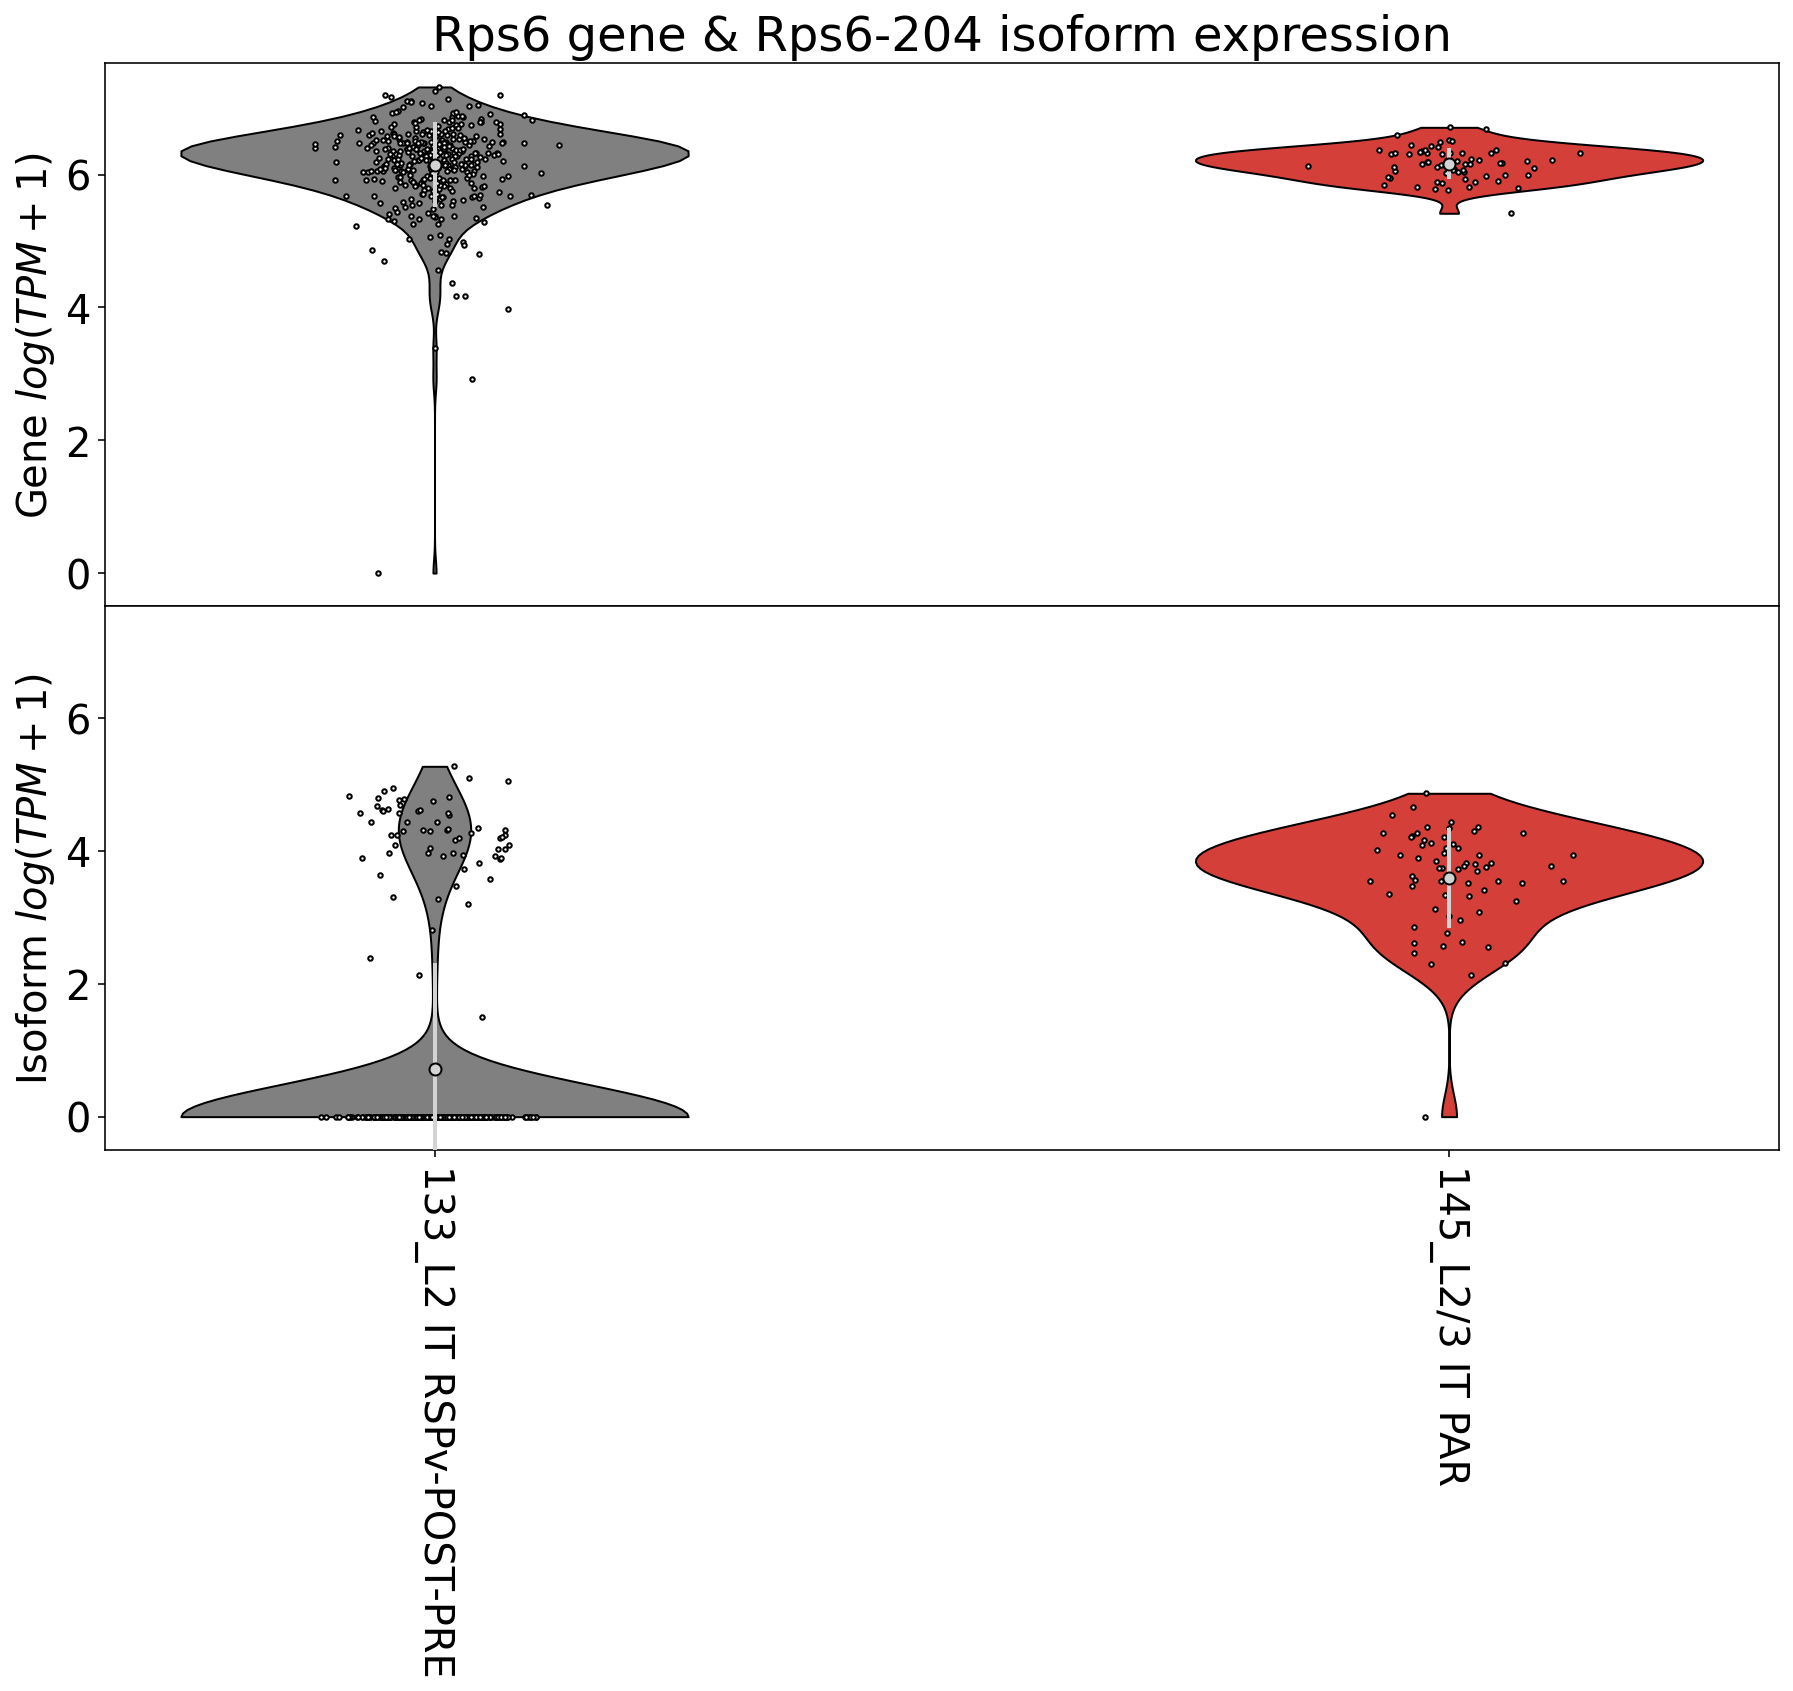

In [46]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene_f.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
plt.xticks(rotation=270)
## Plot
# Gene
x = []
for c in unique:
    #x.append(np.asarray(isoform_f[isoform_f.obs.cluster_label==c][:,isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
    x.append(np.asarray(gene_f[gene_f.obs.cluster_label==c][:,gene_f.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform_f[isoform_f.obs.cluster_label==c][:,isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)


## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5
})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})


plt.savefig("../../../figures/cluster_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [47]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib import cm

In [48]:
num_NCA = 5
state = 42
num_PCA = 10
num_TSNE = 2
metric = "euclidean"

In [49]:
X = gene_f.X

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [50]:
# NCA
X = Y
y = gene_f.obs.cluster_id.values.astype(int)

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
YY = nca.fit_transform(X, y)

In [51]:
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
YYY = tsne.fit_transform(YY)

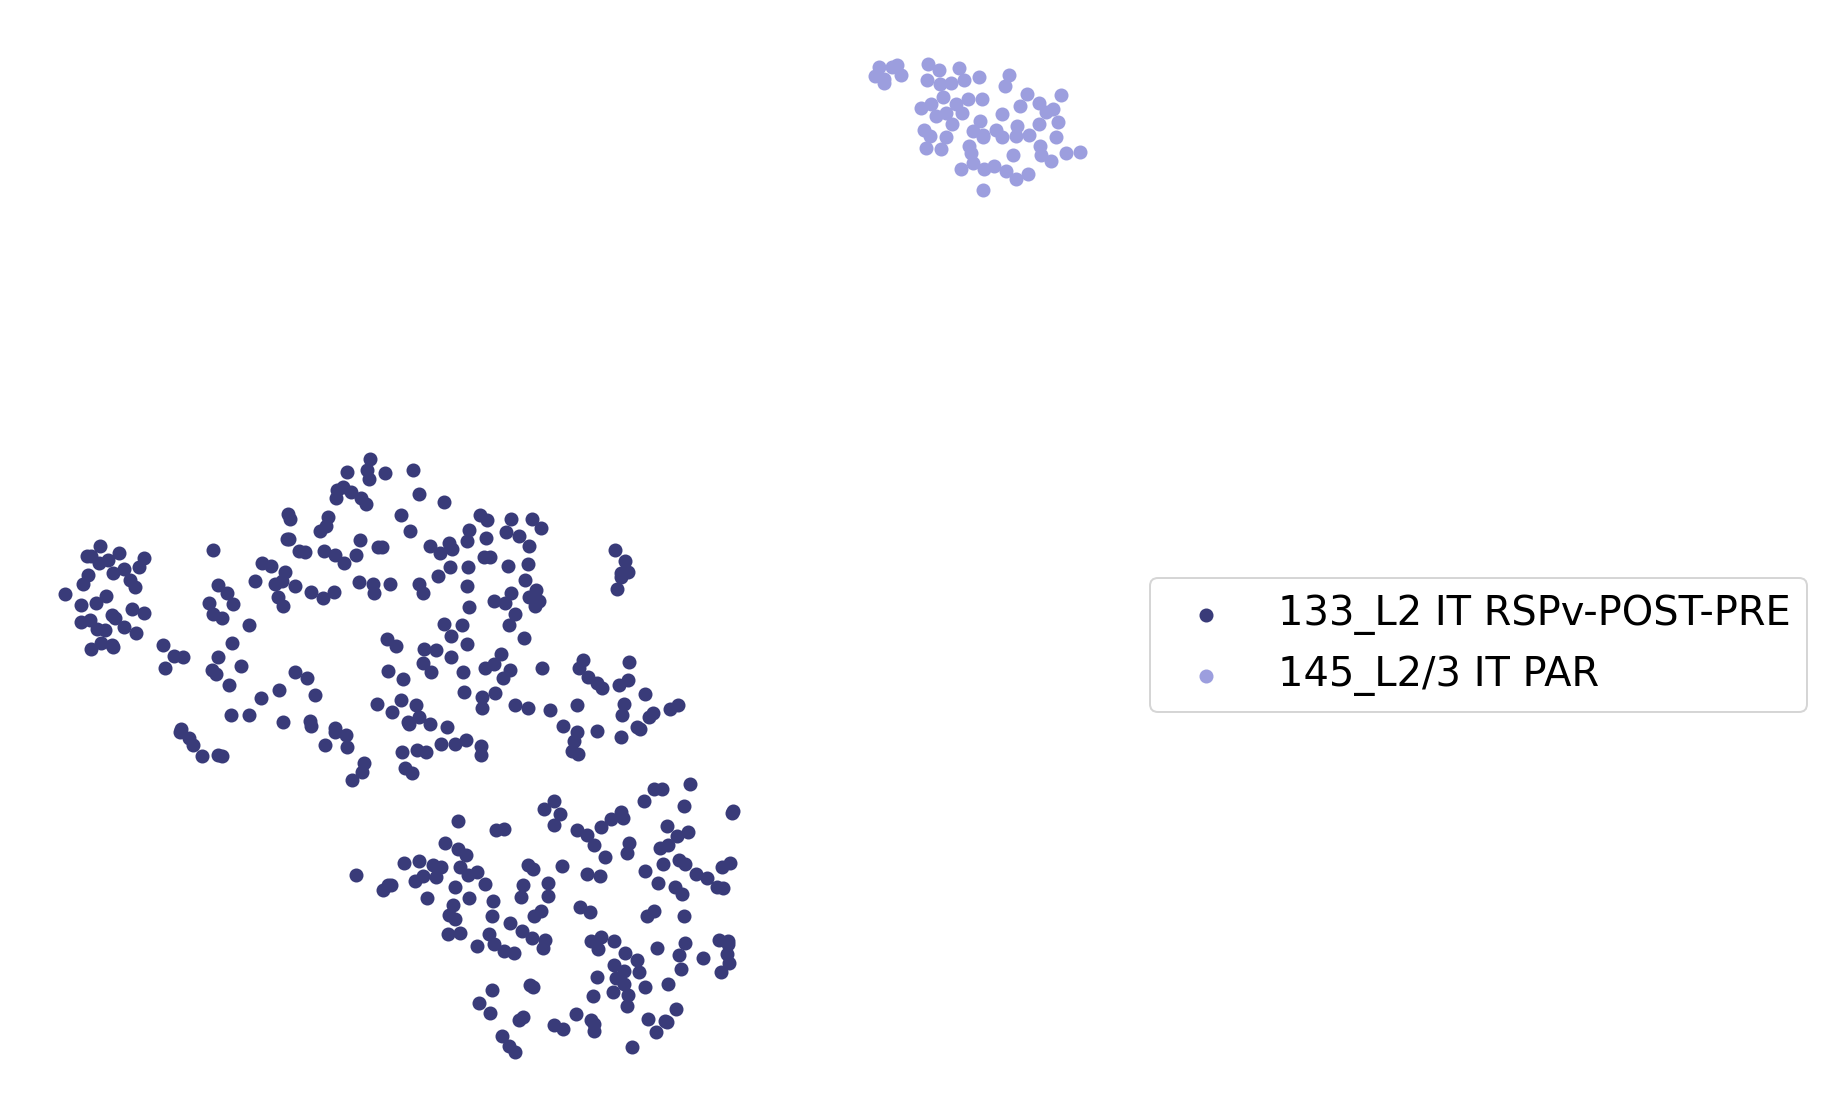

In [52]:
fig, ax = plt.subplots(figsize=(10,10))

x = YYY[:,0]
y = YYY[:,1]
c = cm.get_cmap("tab20b")
assignments = gene_f.obs.cluster_label.values
unique = np.unique(assignments)

for uidx, u in enumerate(unique):
    mask = assignments==u
    xx = x[mask]
    yy = y[mask]
    ax.scatter(xx, yy, color=c(uidx*3), cmap="tab20b", label=u)


ax.legend(bbox_to_anchor=(1, 0.5))

ax.set_axis_off()
plt.show()

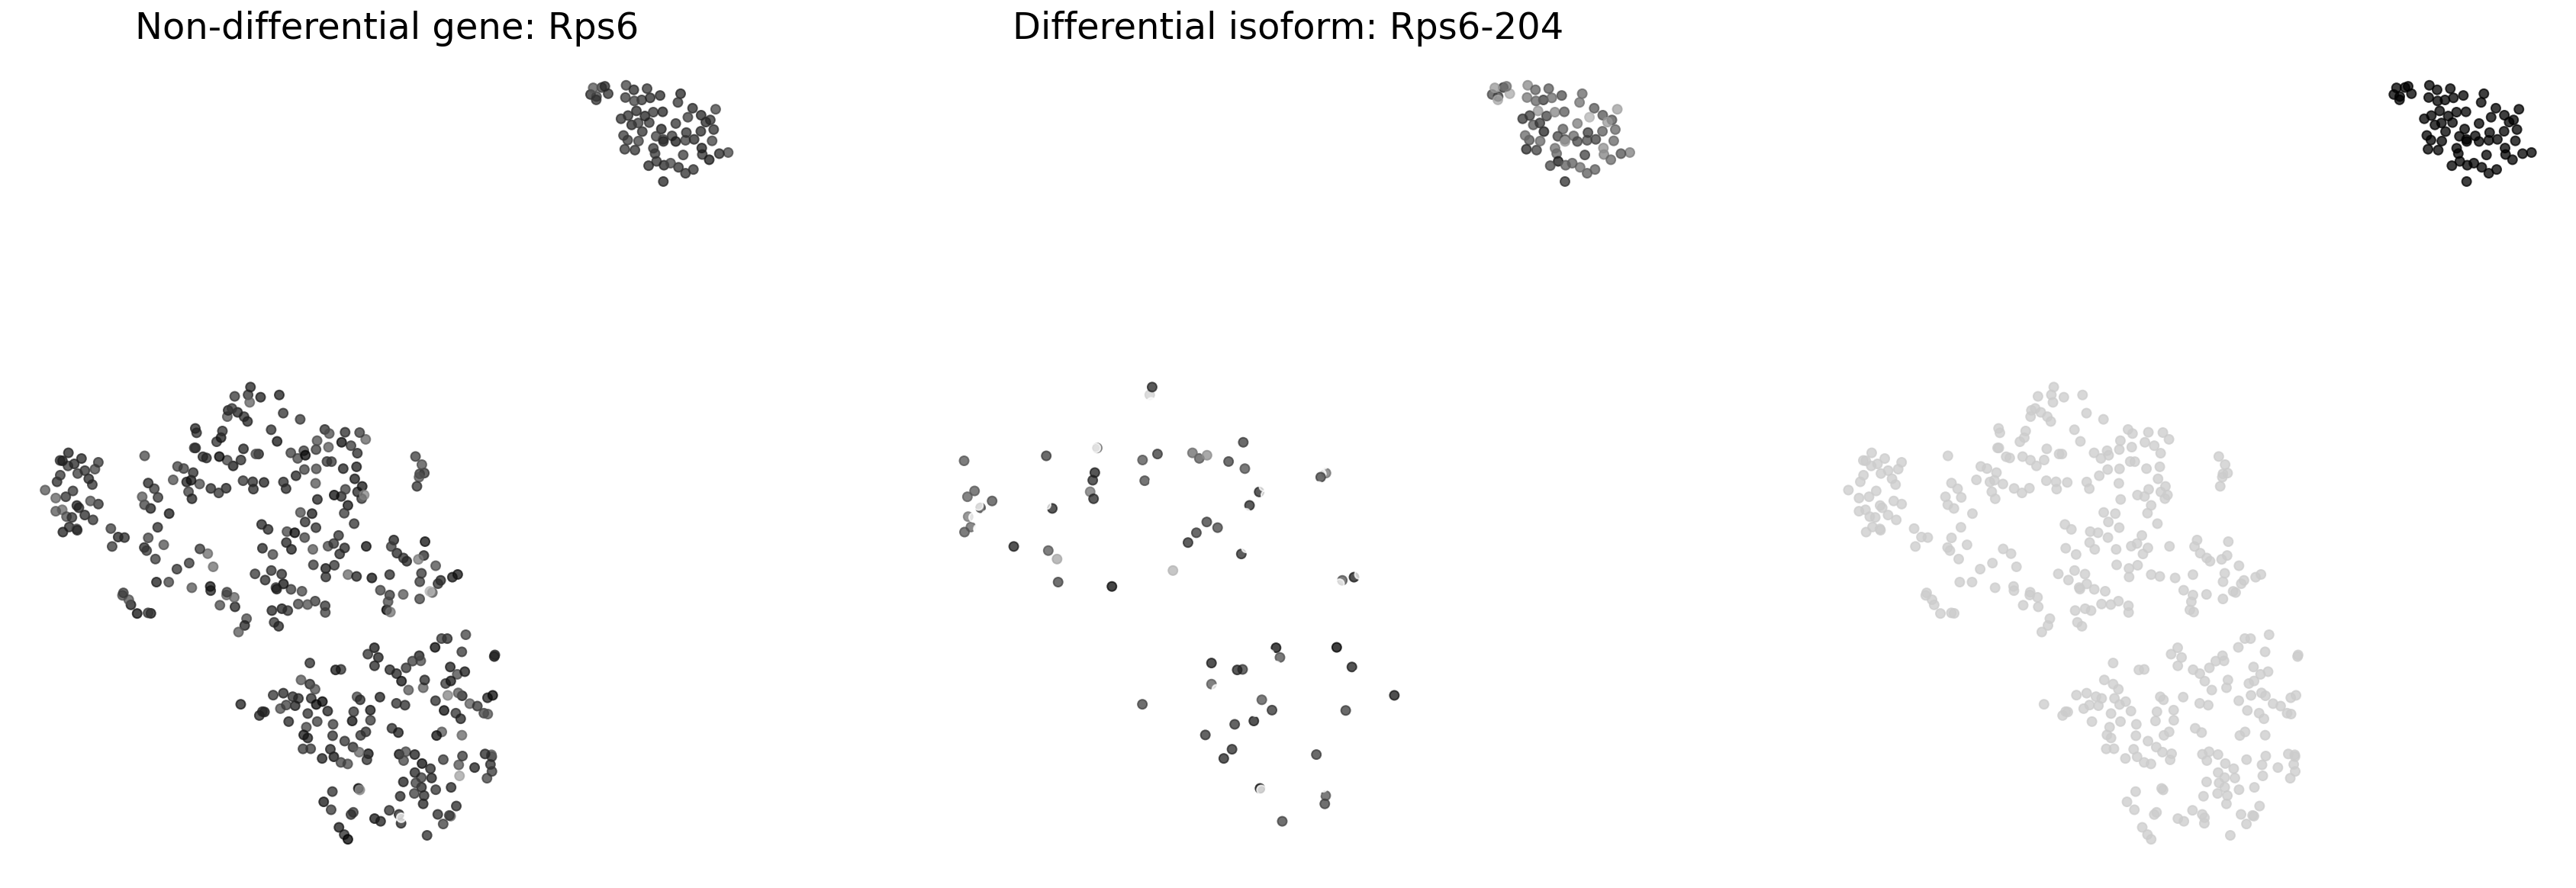

In [53]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = YYY[:,0]
y = YYY[:,1]
c = np.asarray(gene_f[:, gene_f.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = YYY[:,0]
y = YYY[:,1]
c = np.asarray(isoform_f[:, isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = YYY[:,0]
y = YYY[:,1]

c = gene_f.obs["cluster_id"].values.astype(int)
c = gene_f.obs["cluster_label"]==specific_cluster

alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)

ax[2].set_axis_off()
#ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("../../../figures/cluster_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()